<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/03_Convolutional_Neural_Networks_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!nvidia-smi

Fri Mar 19 02:13:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Introduction to Computer Vision / CNN with TensorFlow
Computer vision is a practice of writing algorithm which can discover patters in visual data. Such as a camera of a self-driving car recognizing the car in front.
## What we're going to cover?

- Getting a dataset to work with (pizza_steak). 
- Architecture of a **convolutional neural network** (CNN) with TensorFlow. 
- And end-to-end binary image classification problem. 
- Steps in modelling with CNNs. 
  * Creating a CNN model. 
  * Compiling a model.
  * Fitting a model. 
  * Evaluating a model
* An end-to-end multi-class image classification problem. 
* Making predicitons on our custom images.

In [5]:
import tensorflow as tf

## Get the data 

The images we're working with are from the Food101 dataset(101 different classes). However we've modified it to only use two classes (pizza and steak) using the [image data modification notebook ](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)

🔑 **Note:** We start with smaller dataset so we can experiment quickly and figure out what works (or better yet what doesn't) before scaling up. 

In [6]:
import zipfile 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip # get this file and download it

# Unzip the downloaded file 
zip_ref = zipfile.ZipFile('/content/pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

--2021-03-19 02:13:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.217.7.176, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (105M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.50M  47.2MB/s    in 2.2s    

2021-03-19 02:13:43 (47.2 MB/s) - ‘pizza_steak.zip’ saved [109579078/109579078]



## Inspecting the data (Becoming one with the data)
We gotta draw a idea about the data in our mind before writing any code at first. 

A very crucial step at the beginning of any machine learning project is to become one with the data. And for computer vision project this usually means visualizing many samples of our data. 


In [7]:
# List the files in the folder
!ls pizza_steak/

test  train


In [8]:
# Into the train folder 
!ls pizza_steak/train

pizza  steak


In [9]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

Wow! that's a bunch of images, let's find how many of them are in there. 

In [10]:
import os

# Walk through pizza_steak directory and list number of files 
for dirpath , dirnames , filenames in os.walk('pizza_steak'): # pass in the file you wanna walkthrough
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}"')



There are 2 directories and 1 images in "pizza_steak"
There are 2 directories and 1 images in "pizza_steak/test"
There are 0 directories and 250 images in "pizza_steak/test/steak"
There are 0 directories and 250 images in "pizza_steak/test/pizza"
There are 2 directories and 1 images in "pizza_steak/train"
There are 0 directories and 750 images in "pizza_steak/train/steak"
There are 0 directories and 750 images in "pizza_steak/train/pizza"


`.DS_Store` --> considered as a image in the directory
- pizza
  * train --> 750 images
  * test --> 250 images
- steak 
  * train --> 750 images
  * test --> 250 images

We just saw how to see the filenames in the directory, now will look into how a image looks exactly by visualizing it. 

In [11]:
# Another way to find out how many images are in a file 
num_steak_images_train = len(os.listdir('pizza_steak/train/steak')) # directly inspecting with listdir
num_steak_images_train

750

To visualize our images, first let's get the class names programmatically. 

In [12]:
# Get the class names programmatically
import pathlib 
import numpy as np 
data_dir = pathlib.Path('pizza_steak/train') # turned into a path object 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # Creates a list of class names from sub directories
class_names = class_names[1:] # indexing off DS_STORE
print(class_names)

['pizza' 'steak']


**Let's Visualize some images**

In [13]:
# Visualzing the images 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 
import random 

def view_random_image(target_dir , target_class): 
  '''
  Select an image randomly from the path regardless the class and plot the image for us. 
  '''
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class
  
  # Get a random image path 
  random_image = random.sample(os.listdir(target_folder) , 1) # randomly get one (1) of the items from here
  print(f'The random_image variable returns: {random_image}')

  # Read in the image and plot it using matplotlib 
  img = mpimg.imread(target_folder + '/' + random_image[0])
  #img = cv2.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class) # Displaying whether it's pizza or steak depending upon the image getting plotted
  plt.axis('off'); # we don't want the axes

  print(f'Image shape: {img.shape}') # show the shape of a image

  return img # returns a image at a last

The random_image variable returns: ['830007.jpg']
Image shape: (287, 512, 3)


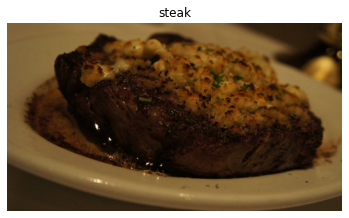

In [14]:
# View random image from the training dataset 
img = view_random_image(target_dir= 'pizza_steak/train/' , 
                        target_class = 'steak') # wanna see a image of steak

The random_image variable returns: ['179165.jpg']
Image shape: (512, 382, 3)


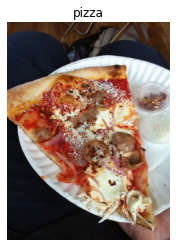

In [15]:
# Let's check soem pizza images 
pizza_img = view_random_image(target_dir = 'pizza_steak/train/' , 
                              target_class = 'pizza')

In [16]:
# What does img looks like ? 
img

array([[[127,  98,  56],
        [127,  98,  56],
        [127,  98,  56],
        ...,
        [ 62,  41,  14],
        [ 57,  37,  12],
        [ 54,  34,  10]],

       [[127,  98,  56],
        [127,  98,  56],
        [127,  98,  56],
        ...,
        [ 61,  40,  13],
        [ 55,  35,  11],
        [ 52,  32,   8]],

       [[127,  98,  56],
        [127,  98,  56],
        [127,  98,  56],
        ...,
        [ 58,  38,  13],
        [ 53,  33,   9],
        [ 47,  29,   7]],

       ...,

       [[ 51,  38,  19],
        [ 51,  38,  19],
        [ 50,  37,  18],
        ...,
        [ 57,  40,  22],
        [ 57,  40,  22],
        [ 57,  40,  22]],

       [[ 52,  39,  20],
        [ 51,  38,  19],
        [ 50,  37,  18],
        ...,
        [ 57,  40,  22],
        [ 57,  40,  22],
        [ 57,  40,  22]],

       [[ 52,  40,  18],
        [ 51,  39,  17],
        [ 50,  37,  18],
        ...,
        [ 57,  40,  22],
        [ 57,  40,  22],
        [ 57,  40,  22]]

In [17]:
# Turning the array into a tensor 
tf.constant(img) # pre-processing array into tensors

<tf.Tensor: shape=(287, 512, 3), dtype=uint8, numpy=
array([[[127,  98,  56],
        [127,  98,  56],
        [127,  98,  56],
        ...,
        [ 62,  41,  14],
        [ 57,  37,  12],
        [ 54,  34,  10]],

       [[127,  98,  56],
        [127,  98,  56],
        [127,  98,  56],
        ...,
        [ 61,  40,  13],
        [ 55,  35,  11],
        [ 52,  32,   8]],

       [[127,  98,  56],
        [127,  98,  56],
        [127,  98,  56],
        ...,
        [ 58,  38,  13],
        [ 53,  33,   9],
        [ 47,  29,   7]],

       ...,

       [[ 51,  38,  19],
        [ 51,  38,  19],
        [ 50,  37,  18],
        ...,
        [ 57,  40,  22],
        [ 57,  40,  22],
        [ 57,  40,  22]],

       [[ 52,  39,  20],
        [ 51,  38,  19],
        [ 50,  37,  18],
        ...,
        [ 57,  40,  22],
        [ 57,  40,  22],
        [ 57,  40,  22]],

       [[ 52,  40,  18],
        [ 51,  39,  17],
        [ 50,  37,  18],
        ...,
        [ 57,  40,  2

In [18]:
img / 255

array([[[0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        ...,
        [0.24313725, 0.16078431, 0.05490196],
        [0.22352941, 0.14509804, 0.04705882],
        [0.21176471, 0.13333333, 0.03921569]],

       [[0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        ...,
        [0.23921569, 0.15686275, 0.05098039],
        [0.21568627, 0.1372549 , 0.04313725],
        [0.20392157, 0.1254902 , 0.03137255]],

       [[0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        ...,
        [0.22745098, 0.14901961, 0.05098039],
        [0.20784314, 0.12941176, 0.03529412],
        [0.18431373, 0.11372549, 0.02745098]],

       ...,

       [[0.2       , 0.14901961, 0.0745098 ],
        [0.2       , 0.14901961, 0.0745098 ],
        [0.19607843, 0

In [19]:
# View the image shape 
img.shape # return (width , height , color channel)

(287, 512, 3)

We can pass this array in our model, but it's often important to pre-process our data before injecting them into a model or other words **(scale or normalize our data)**. 

In [20]:
# Get all the pixel values btw 0 and 1
img / 255.

array([[[0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        ...,
        [0.24313725, 0.16078431, 0.05490196],
        [0.22352941, 0.14509804, 0.04705882],
        [0.21176471, 0.13333333, 0.03921569]],

       [[0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        ...,
        [0.23921569, 0.15686275, 0.05098039],
        [0.21568627, 0.1372549 , 0.04313725],
        [0.20392157, 0.1254902 , 0.03137255]],

       [[0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        [0.49803922, 0.38431373, 0.21960784],
        ...,
        [0.22745098, 0.14901961, 0.05098039],
        [0.20784314, 0.12941176, 0.03529412],
        [0.18431373, 0.11372549, 0.02745098]],

       ...,

       [[0.2       , 0.14901961, 0.0745098 ],
        [0.2       , 0.14901961, 0.0745098 ],
        [0.19607843, 0

🔑 **Dan Note:** As we've discussed before, many machine learning models, including neural networks perfer the values they work with to be between 0 and 1. Knowing this, one of the most common pre-processing steps for working with images is to **scale** (also reffered to as **normalize**) their pixel values by dividing the image arrays by 255. (since 255 is the maximum pixel value). 

## An end-to-end example 

Let's build a cnn to find patterns in our images, more specifically we need a way to: 
- Load our images. 
- Pre-process our images. (scale)
- Build a cnn model to find patterns in our images
- Compile the cnn model. 
- Fit the cnn model. 

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed 
tf.random.set_seed(42)

# Pre-process data (gets all of the pixel values between 0 and 1, also called scaling , normalization)
# To do this we're going to setup two instances of ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# Setup paths to our data directories
train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

# Import data from directories and turn it into batches
# It gets data and create labels automatically for us
train_data = train_datagen.flow_from_directory(directory = train_dir , 
                                               batch_size = 32 , 
                                               target_size = (224 , 224) , 
                                               class_mode = 'binary' , 
                                               seed = 42) # passing the train_dir into the datagenerator

valid_data = valid_datagen.flow_from_directory(directory = test_dir , 
                                               batch_size = 32 , 
                                               target_size = (224 , 224) , 
                                               class_mode = 'binary' , 
                                               seed = 42)

# Building a CNN model (same as a Tiny VGG model)
model_0 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 10 , 
                           kernel_size = 3 , 
                           activation = tf.keras.activations.relu , 
                           input_shape = (224, 224 , 3)),  # input shape our first layer is gonna take

    tf.keras.layers.Conv2D(10 , 3 , activation= tf.keras.activations.relu) , 
    tf.keras.layers.MaxPool2D(pool_size= 2, 
                              padding = 'valid'), 
    tf.keras.layers.Conv2D(10 , 3, activation= tf.keras.activations.relu), 
    tf.keras.layers.Conv2D(10 , 3 , activation= tf.keras.activations.relu) , 
    tf.keras.layers.MaxPool2D(2) , 
    tf.keras.layers.Flatten() ,  # flattening before sending to output layer
    tf.keras.layers.Dense(1 , activation= tf.keras.activations.sigmoid)
])

# Compile our CNN model 
model_0.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])



Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [22]:
# Fit the model 
history_0 = model_0.fit(train_data , epochs = 5 , 
                        steps_per_epoch = len(train_data) , # 47 steps per epoch
                        validation_data =  valid_data , 
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 43s 211ms/step - loss: 0.6483 - accuracy: 0.5849 - val_loss: 0.4565 - val_accuracy: 0.7680
Epoch 2/5
47/47 [==============================] - 9s 189ms/step - loss: 0.4383 - accuracy: 0.7970 - val_loss: 0.3549 - val_accuracy: 0.8420
Epoch 3/5
47/47 [==============================] - 9s 192ms/step - loss: 0.4214 - accuracy: 0.7990 - val_loss: 0.3573 - val_accuracy: 0.8460
Epoch 4/5
47/47 [==============================] - 9s 195ms/step - loss: 0.3489 - accuracy: 0.8461 - val_loss: 0.3577 - val_accuracy: 0.8440
Epoch 5/5
47/47 [==============================] - 9s 192ms/step - loss: 0.3330 - accuracy: 0.8572 - val_loss: 0.3026 - val_accuracy: 0.8580


**Breaking down the code above**
- `target_size` --> A default size we want all of our images should be, for instance images with different shapes might exists in there. But we want to turn all them into a uniform stable size. 
- `class_mode = 'binary'` --> we are importing our data in a binary (2 classes) or we are dealing with a binary classification problem. 

In [23]:
# Checking how our data is been taken into the model 
print(f'We have {len(train_data)} batches of 32 images in each of them')
print(f'Its by the calculation 1500 / 32 = {1500 / 32}')

We have 47 batches of 32 images in each of them
Its by the calculation 1500 / 32 = 46.875


In [24]:
# Get a model summary 
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

## Using the same model as before 

Let's replicate the model we've built in previous section to see if it works with our image data.

The model we're building is from TensorFlow Playground 

In [25]:
# Set random seed 
tf.random.set_seed(42)

# Create a model to replicate tensorflow playrgound model 
model_1 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape = (224 , 224, 3)), 
  tf.keras.layers.Dense(4 , activation='relu'),
  tf.keras.layers.Dense(4 , activation='relu'),
  tf.keras.layers.Dense(1 , activation='sigmoid')
])

# Compile the model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# Fit the data 
history_1 = model_1.fit(train_data , 
                        epochs = 5 , 
                        steps_per_epoch = len(train_data) , 
                        validation_data = valid_data , 
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 181ms/step - loss: 2.1716 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 8s 176ms/step - loss: 0.6933 - accuracy: 0.4928 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 8s 178ms/step - loss: 0.6930 - accuracy: 0.5160 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 8s 177ms/step - loss: 0.6932 - accuracy: 0.4929 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 8s 176ms/step - loss: 0.6931 - accuracy: 0.5130 - val_loss: 0.6932 - val_accuracy: 0.5000


In [26]:
# Getting the model_1 summary 
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Despite having 20X more parameters than our CNN model, model_1 performs terribly.  Let's try fixing it.

In [27]:
# Set random seed 
tf.random.set_seed(42)

# Create the model with (same as above let's improve)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape = (224 , 224 , 3)),
  tf.keras.layers.Dense(100 , activation= 'relu'), 
  tf.keras.layers.Dense(100 , activation = 'relu'), 
  tf.keras.layers.Dense(100 , activation= 'relu') , 
  tf.keras.layers.Dense(1,  activation = 'sigmoid')

])

# Compile the model 
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# Fit the model 
history_2 = model_2.fit(train_data,  
                        epochs = 5 , 
                        steps_per_epoch = len(train_data) , 
                        validation_data = valid_data , 
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 181ms/step - loss: 5.0306 - accuracy: 0.5839 - val_loss: 1.0869 - val_accuracy: 0.6340
Epoch 2/5
47/47 [==============================] - 8s 173ms/step - loss: 1.0062 - accuracy: 0.6844 - val_loss: 0.7635 - val_accuracy: 0.7560
Epoch 3/5
47/47 [==============================] - 8s 173ms/step - loss: 0.7651 - accuracy: 0.7188 - val_loss: 1.0075 - val_accuracy: 0.5980
Epoch 4/5
47/47 [==============================] - 8s 175ms/step - loss: 0.6447 - accuracy: 0.7260 - val_loss: 0.5648 - val_accuracy: 0.6960
Epoch 5/5
47/47 [==============================] - 8s 175ms/step - loss: 0.5353 - accuracy: 0.7471 - val_loss: 0.6821 - val_accuracy: 0.7140


Not bad, by adding a layer and increasing the number of hidden units we're able to increase the accuracy on our validation set. But it's always good to use a CNN architecture for an image (vision) problem. 

Eventhough running the above model or further tweaks won't get us any far. 

🔑 **Dan Note:** You can think of **trainable parameters** as a patterns a model can learn from the data. Intuitiely, you might think more is better. And in some case it is. But in this case, the difference here is in the two different styles of model we're using. Where a series of dense layers have a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, a **convolutional neural network** seeks to sort out and learn the most important patterns in an image. So even though there are less learnable parameters in our convolutional neural network , these are often more helpful in decephering between **different features** in an image. 

In [28]:
# We have fewer learnable params in CNN model than other model's 
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

## Binary Classification: Let's break it down

1. Become one with the data (visualize, visualize , visualize).
2. Pre-process the data (prepared it for the model, the main thing was scaling / normalizing). 
3. Create a model (start with a baseline)
4. Fit the model 
5. Evaluate the model 
6. Adjust different parameters (and try to beat the baseline). 
7. Repeat until satisfied (experiment -- experiment -- experiment)

### 1. Become one with the data

The random_image variable returns: ['1530833.jpg']
Image shape: (512, 512, 3)
The random_image variable returns: ['2999507.jpg']
Image shape: (512, 306, 3)
The random_image variable returns: ['60655.jpg']
Image shape: (384, 512, 3)
The random_image variable returns: ['3871666.jpg']
Image shape: (512, 512, 3)


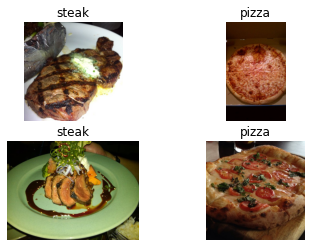

In [29]:
# Visualize data 
plt.figure()
plt.subplot(2, 2, 1)
steak_img1 = view_random_image('pizza_steak/train/' , 'steak')
plt.subplot(2, 2, 2)
pizza_img1 = view_random_image('pizza_steak/train/' , 'pizza')
plt.subplot(2 , 2, 3)
steak_img2 = view_random_image('pizza_steak/train/' , 'steak')
plt.subplot(2, 2 , 4)
pizza_img2 = view_random_image('pizza_steak/train/' , 'pizza')


### 2. Pre-process the data (prepare it for model)

In [30]:
# Define our directory dataset paths 
train_dir = 'pizza_steak/train/'
test_dir = 'pizza_steak/test/'



Our next step is to turn our data into **batches** (a small subset of a dataset that a model looks during training). 

A batch is a small subset of data rather than looking at all 10k images at one time, a model might only look at 32 at a time. It does this for couple of reasons: 
- 10,000 images (or more) might not fit into the memory of the processor (GPU).
- Try to learn patterns in 10,000 images in one hit (or at a time) could result in the model not being able to learn very well. 

**Why 32?**
One of the common batch size (Yann LeCun) 

In [31]:
# Create train and test data generator and rescale the data (load the data)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale= 1/255.) # It's a class
test_datagen = ImageDataGenerator(rescale= 1/255.) # divide all images by 255 

We made the class to handle the transforms now we need a way to connect our data with this datagenerator to get going. In other words find a way to get our data from directories and load them in. 

In [32]:
# Load in our image data from directories and turn them into batches 
train_data = train_datagen.flow_from_directory(directory= train_dir , # target directory of images
                                               target_size = (224 , 224) , # target size of images (height , width)
                                               class_mode = 'binary' ,  # type of data you're working wiht
                                               batch_size = 32) # size of mini-batches to load data into 

test_data = test_datagen.flow_from_directory(directory= test_dir , 
                                             target_size = (224 , 224) , 
                                             class_mode = 'binary' , 
                                             batch_size = 32)



Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [33]:
# Get a sample of train data batch 
images , labels = train_data.next() # Get the next batch of images , labels in train data
len(images) , len(labels)

(32, 32)

In [34]:
# How many batches are there 
len(train_data) # 1500 / 32 = 47 approx (rounds up)

47

In [35]:
# Get the first 2 images 
images[:2] # pixel values are scaled between 0 -1 


array([[[[0.47058827, 0.40784317, 0.34509805],
         [0.4784314 , 0.427451  , 0.3647059 ],
         [0.48627454, 0.43529415, 0.37254903],
         ...,
         [0.8313726 , 0.70980394, 0.48627454],
         [0.8431373 , 0.73333335, 0.5372549 ],
         [0.87843144, 0.7725491 , 0.5882353 ]],

        [[0.50980395, 0.427451  , 0.36078432],
         [0.5058824 , 0.42352945, 0.35686275],
         [0.5137255 , 0.4431373 , 0.3647059 ],
         ...,
         [0.82745105, 0.7058824 , 0.48235297],
         [0.82745105, 0.70980394, 0.5058824 ],
         [0.8431373 , 0.73333335, 0.5372549 ]],

        [[0.5254902 , 0.427451  , 0.34901962],
         [0.5372549 , 0.43921572, 0.36078432],
         [0.5372549 , 0.45098042, 0.36078432],
         ...,
         [0.82745105, 0.7019608 , 0.4784314 ],
         [0.82745105, 0.7058824 , 0.49411768],
         [0.8352942 , 0.7176471 , 0.5137255 ]],

        ...,

        [[0.77647066, 0.5647059 , 0.2901961 ],
         [0.7803922 , 0.53333336, 0.22352943]

In [36]:
# Shape of 1st image 
print(f'Shape of one image: {images[0].shape}')

Shape of one image: (224, 224, 3)


In [37]:
# Viewing the labels 
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### 3. Create a CNN model (start with a baseline)

A baseline is a relatively simple model or existing result that you setup when beginning a machine learning experiment and then as you keep experimenting, you try to beat the baseline. 

> 🔑 **Dan Note** In deeplearning, there is almost an infinite amount of architecture you could create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required (e.g. look at which current model is performing best in the field for your problem).

In [38]:
# Make the creating of our model little easier 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten , Conv2D , MaxPool2D , Activation
from tensorflow.keras  import Sequential

In [39]:
# Create baseline model (3 layer cnn)
model_3 = Sequential([
  Conv2D(filters = 10 , # sliding window goes across the input (higher = complex modle)
         kernel_size = 3 , # Size of the sliding window going across an input
         strides = 1 , # the size of the step the sliding window takes across an input
         padding = 'valid' , # if 'same' o/p shape is same as i/p shape, if 'valid' o/p shape gets compressed
         activation = 'relu' , 
         input_shape = (224 , 224, 3)), # Input layer specify input shape
  Conv2D(10 , 3 , activation='relu') , 
  Conv2D(10 , 3 , activation = 'relu') , 
  Flatten() , 
  Dense(1 , activation= 'sigmoid') # output layer (we're dealing with Binary Classification)

  ]) # The features are learned by the layers we wrote above

# Compile the model 
model_3.compile(loss = tf.keras.losses.BinaryCrossentropy() ,  # because of pizza and steak
                optimizer = tf.keras.optimizers.Adam() ,  
                metrics = ['accuracy'])

In [40]:
# Get a summary of our model, how the input shape changes throughout
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### 4. Fit the model 



In [41]:
# Check the lenght of train and test datagenerators
len(train_data)  , len(test_data) # printed out in batches 

(47, 16)

In [42]:
# Fit the model 
history_3 = model_3.fit(train_data , # Combo of labelled and sample data (imgs)
                        epochs  = 5 , 
                        steps_per_epoch = len(train_data) , # take 47 steps for each epoch
                        validation_data = test_data , 
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 10s 196ms/step - loss: 2.9426 - accuracy: 0.5430 - val_loss: 0.4870 - val_accuracy: 0.7720
Epoch 2/5
47/47 [==============================] - 9s 191ms/step - loss: 0.4975 - accuracy: 0.7816 - val_loss: 0.4863 - val_accuracy: 0.8360
Epoch 3/5
47/47 [==============================] - 9s 193ms/step - loss: 0.4202 - accuracy: 0.8378 - val_loss: 0.3633 - val_accuracy: 0.8240
Epoch 4/5
47/47 [==============================] - 9s 193ms/step - loss: 0.2948 - accuracy: 0.8944 - val_loss: 0.3917 - val_accuracy: 0.8380
Epoch 5/5
47/47 [==============================] - 9s 192ms/step - loss: 0.1708 - accuracy: 0.9536 - val_loss: 0.3967 - val_accuracy: 0.8140


In [43]:
# Checking the results of our model_0 
model_0.evaluate(test_data)

16/16 [==============================] - 2s 131ms/step - loss: 0.3026 - accuracy: 0.8580


[0.3026391267776489, 0.8579999804496765]

In [44]:
# And what's the missing piece? let's check how it's build and are we missing anything 
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

Alrighty!! Seems we are missing out `MaxPool2D` layer in our model. Maybe adding that in our model might help in increasing the accuracy of our model and helps to learn the patterns in our dat better.

### 5. Evaluate our model 

It's looks like our model is learning something, let's evaluate it. There are two ways we can check it out:
- Plotting the loss curve
- Using some evaluation metrics

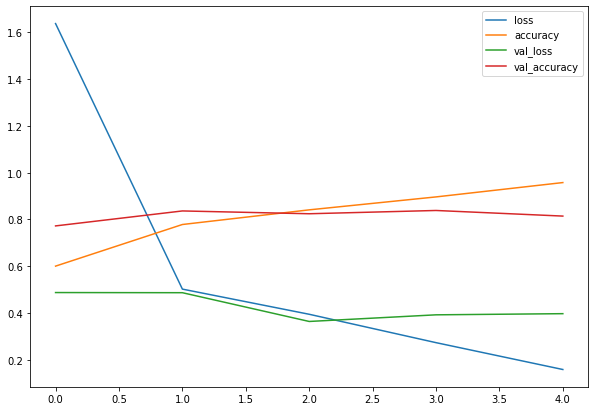

In [45]:
# Let's plot the loss curve 
import pandas as pd
pd.DataFrame(history_3.history).plot(figsize = (10 , 7))

In [46]:
# Plot the validation and training curve seperately 
def plot_loss_curves(history):
  '''
  Returns deperate loss curves for training and validation metrics
  '''
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss'])) # how many epochs did we run for 

  # Plotting the loss at first 
  plt.plot(epochs , loss , label = 'training_loss')
  plt.plot(epochs , val_loss , label = 'validation_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot the accuracy 
  plt.figure() # everytime we need a figure use it
  plt.plot(epochs , accuracy , label='accuracy')
  plt.plot(epochs , val_accuracy , label = 'validation_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

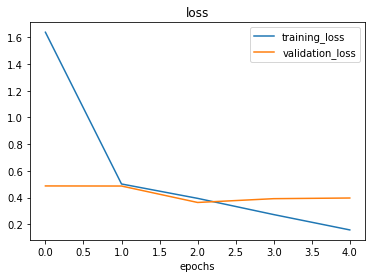

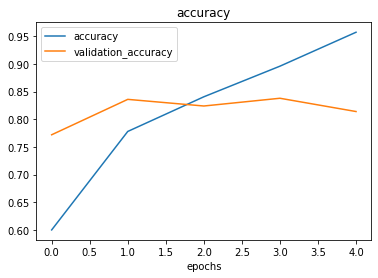

In [47]:
# Check our new functio and plot the curves 
plot_loss_curves(history_3)

> 🔑  **Dan Note:** When our models **validation_loss starts to increase**, it's likely that the model is **overfitting** on the training dataset. This means it learns the patterns in the training dataset too well and thus the model's ability to generalize to unseen data will be diminished. 

### 6. Adjust the model's parameters 

Fitting a machine learning model comes in 3 steps:


0. Create a baseline model.
1. Beat the baseline by overfitting a larger model.
2. Reduce Overfitting. 

Ways to induce overfitting:
- Increase the number of Conv layers (make the network deeper). 
- Increase the number of Conv filters / hidden units. 
- Add another dense layer to the output of our flattened layer.

Reduce Overfitting:
- Add data augmentation. 
- Add Regularization layers such as MaxPool2D.
- Add more data and so on....


> **Dan Note:** Reducing overfitting is also knowns as Regularization

In [48]:
# Create a model  (this is going to be a new base line)

model_4 = tf.keras.Sequential([
  Conv2D(filters = 10 , 
         kernel_size = 3, 
         activation = 'relu' , 
         input_shape = (224 , 224, 3)) , 
  MaxPool2D(pool_size= 2) , 
  Conv2D(10 , 3, activation = 'relu') , 
  MaxPool2D(2) , 
  Conv2D(10 , 3 , activation= 'relu'), 
  MaxPool2D(2) , 
  Flatten() , 
  Dense(1 , activation=  'sigmoid')
])

In [49]:
# Compile the model 
model_4.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

In [50]:
# Fit the model 
history_4 = model_4.fit(train_data , 
                        epochs = 5, 
                        steps_per_epoch = len(train_data) , 
                        validation_data = test_data , 
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 9s 188ms/step - loss: 0.6590 - accuracy: 0.5913 - val_loss: 0.4651 - val_accuracy: 0.7920
Epoch 2/5
47/47 [==============================] - 9s 184ms/step - loss: 0.4804 - accuracy: 0.7848 - val_loss: 0.4129 - val_accuracy: 0.8240
Epoch 3/5
47/47 [==============================] - 9s 182ms/step - loss: 0.4408 - accuracy: 0.7973 - val_loss: 0.4042 - val_accuracy: 0.8200
Epoch 4/5
47/47 [==============================] - 9s 182ms/step - loss: 0.4475 - accuracy: 0.8137 - val_loss: 0.3929 - val_accuracy: 0.8500
Epoch 5/5
47/47 [==============================] - 9s 182ms/step - loss: 0.3909 - accuracy: 0.8387 - val_loss: 0.3661 - val_accuracy: 0.8540


In [51]:
model_4.summary() # Pay attention to the shapes

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)             

We can see by adding the `MaxPooling2D` layer the input is condensed into smaller output and passed onto the next layer. As the layers grows we can see the input image size is reduced. Even the parameters are less than our previous model. 
- `model_3` ---> 477,341 params
- `model_4` ---> 8,861 params

MaxPool layers takes only the max of the features, it condense the features so the model can learn only the important features in an image. 



In [52]:
# Checkig how our model_3 looks like
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


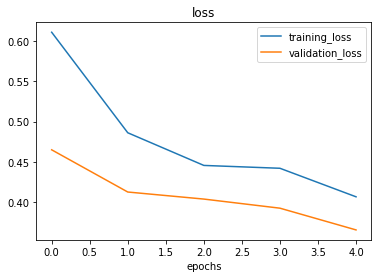

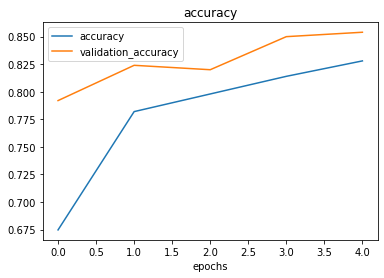

In [53]:
# plot the loss curves 
plot_loss_curves(history_4)

### Opening our bag of tricks and finding data augmentation

In [54]:
# Create ImageDataGenerator training instance with data augmentation 
train_augmented_datagen = ImageDataGenerator(rescale= 1/255. , 
                                             rotation_range = 0.2 , # how much do you want to rotate an image 
                                             shear_range = 0.2 , # how much do you want to shear an image. 
                                             zoom_range = 0.2 , # zoom in randomly on an image
                                             #width_shift_range = 0.2 , # move your image around in x-axis
                                             #height_shift_range = 0.3 , # move your image around in y-axis
                                             horizontal_flip = True  # do you want to flip an image 
                                             )

# Create ImageDataGenerator withot data augmentation 
train_datagen = ImageDataGenerator(rescale = 1/255.)

# Create ImageDataGenerator without data augmentation for testing 
test_datagen = ImageDataGenerator(rescale = 1/255.)


> **😐 What is data augmentation?**

Data Augmentation is the process of altering our training data and leaving it to have more diversity and in turn allowing our models to learn more generalizable patterns (hopefully) patterns. 

Altering might mean adjusting the rotation of an image, flipping the image, cropping an image etc...

Let's write some code to visualize data augmentation 

In [55]:
# Import data and augment it from the training directory
print('Augmented training data')
train_data_augmented = train_augmented_datagen.flow_from_directory(train_dir , 
                                                                   target_size = (224 , 224) , 
                                                                   batch_size = 32 , 
                                                                   class_mode = 'binary' , 
                                                                   shuffle = False ) # for demo purpose only

# Create non-augmented train data batches 
print('\nNon Augmented training data')
train_data = train_datagen.flow_from_directory(train_dir , 
                                               target_size = (224 , 224) , 
                                               batch_size = 32 , 
                                               class_mode = 'binary' , 
                                               shuffle = False)

IMG_SIZE = (224, 224)
# Create non-augmented test data batches 
print('\nNon Augmented test data')
test_data = test_datagen.flow_from_directory(test_dir , 
                                             target_size = IMG_SIZE , 
                                             batch_size = 32 , 
                                             class_mode = 'binary' , 
                                             shuffle = True)


Augmented training data
Found 1500 images belonging to 2 classes.

Non Augmented training data
Found 1500 images belonging to 2 classes.

Non Augmented test data
Found 500 images belonging to 2 classes.


>🔑 **Dan Note:** Data Augmentation is usually only performed on the training data. Using `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but our modified as they're loaded into the model. 

Finally let's visualize some augmented data!!

In [56]:
# Get sample data batches 
images , labels = train_data.next() # Not augmented 

# Augmented images and lables from the batches 
augmented_images , augmented_labels = train_data_augmented.next()  # labels aren't augmented 


Showing Image number: 2


(-0.5, 223.5, 223.5, -0.5)

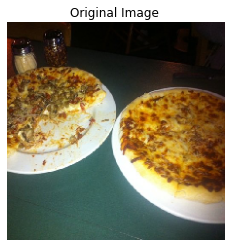

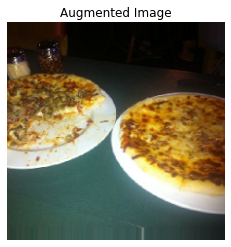

In [57]:
# Show original image and augmented image 
import random 
random_number = random.randint(0 , 31) # Because of 32 batches
print(f'Showing Image number: {random_number}')
plt.imshow(images[random_number])
plt.title(f'Original Image ')
plt.axis(False)
# Augmented one 
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f'Augmented Image')
plt.axis(False)

Now we've seen what augmented data looks like let's build a model and see how it learns on the augmented data!

In [58]:
# Create a model using the data augmenteation 

model_5 = Sequential([
  Conv2D(10 , 3 , activation='relu'), 
  MaxPool2D(pool_size=2) , 
  Conv2D(10 , 3, activation='relu'), 
  MaxPool2D(2) , 
  Conv2D(10 , 3 , activation='relu'), 
  MaxPool2D(2),
  Flatten(), 
  Dense(1 , activation='sigmoid')
])

# Compile the model 
model_5.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ['accuracy'])

# Fit the model 
history_5 = model_5.fit(train_data_augmented , 
                        epochs = 5 , 
                        steps_per_epoch = len(train_data_augmented) , 
                        validation_data = test_data , 
                        validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 22s 450ms/step - loss: 0.7320 - accuracy: 0.4512 - val_loss: 0.6837 - val_accuracy: 0.6180
Epoch 2/5
47/47 [==============================] - 21s 443ms/step - loss: 0.7112 - accuracy: 0.6499 - val_loss: 0.6701 - val_accuracy: 0.6360
Epoch 3/5
47/47 [==============================] - 21s 444ms/step - loss: 0.6737 - accuracy: 0.6130 - val_loss: 0.6616 - val_accuracy: 0.5280
Epoch 4/5
47/47 [==============================] - 21s 440ms/step - loss: 0.6654 - accuracy: 0.5957 - val_loss: 0.5953 - val_accuracy: 0.7680
Epoch 5/5
47/47 [==============================] - 21s 443ms/step - loss: 0.6159 - accuracy: 0.7328 - val_loss: 0.6137 - val_accuracy: 0.6480


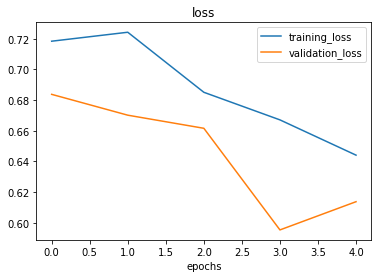

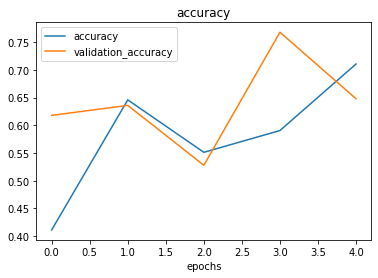

In [59]:
# Check our model's training curves 
plot_loss_curves(history_5)

Let's shuffle our augmented training data and train another model same as before and see what happens

**Discovering the power of shuffle**

In [60]:
# Import data and augment it and shuffle it from the training directory
train_data_augmented_shuffled = train_augmented_datagen.flow_from_directory(train_dir , 
                                                                         target_size = (224, 224) , 
                                                                         class_mode = 'binary' , 
                                                                         shuffle = True) # shuffle data this time

Found 1500 images belonging to 2 classes.


In [61]:
# Create a model (as same as before) 
# We've kept the model same and tweaking our experiments only with the data

model_6 = Sequential([
  Conv2D(10 , 3, activation='relu' , input_shape = (224 , 224, 3)), 
  MaxPool2D(pool_size = 2), 
  Conv2D(10 , 3, activation='relu'), 
  MaxPool2D(2), 
  Conv2D(10 , 3 , activation='relu'),
  MaxPool2D(2),
  Flatten(), 
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# Fit the model 
history_6 = model_6.fit(train_data_augmented_shuffled , 
            epochs = 5 , 
            steps_per_epoch = len(train_data_augmented_shuffled) , 
            validation_data = test_data , 
            validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 21s 444ms/step - loss: 0.6465 - accuracy: 0.5956 - val_loss: 0.4617 - val_accuracy: 0.7980
Epoch 2/5
47/47 [==============================] - 21s 440ms/step - loss: 0.4715 - accuracy: 0.7963 - val_loss: 0.3813 - val_accuracy: 0.8380
Epoch 3/5
47/47 [==============================] - 21s 443ms/step - loss: 0.4441 - accuracy: 0.7952 - val_loss: 0.3518 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 21s 440ms/step - loss: 0.4258 - accuracy: 0.8176 - val_loss: 0.3414 - val_accuracy: 0.8420
Epoch 5/5
47/47 [==============================] - 21s 439ms/step - loss: 0.4175 - accuracy: 0.7970 - val_loss: 0.3461 - val_accuracy: 0.8580


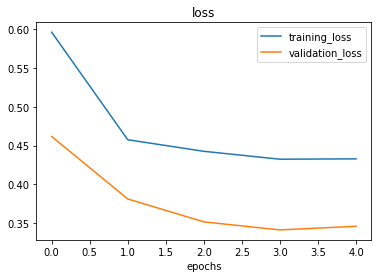

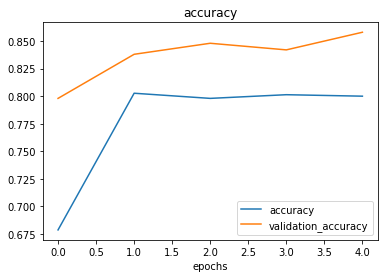

In [62]:
# Plotting the loss curves 
plot_loss_curves(history_6)

Shuffling helps the model to learn patterns from different data, which helps the model to learn patterns in the data better. For instance after going through the pizza image, the model has to adjust it patterns into a image of steak back and forth. 

When shuffling it looks at random images simultaneously, if not shuffled and if our model isn't performing well on training data we should look into shuffling the data.

### 7. Repeat Until Satisfied

Since we've already beaten our baseline there are few things we could try to continue improve our model: 

- Increase the number of model layers (eg add more `Conv2D` / `MaxPool2D` layers). 
- Increase the number of filters in each convolutional layers (e.g from 10 to 32 or even 64). 
- Train for longer(more epochs). 
- Find an ideal learning rate 
- Get more data (give the model more opportunities to learn). 
- Use **transfer learning** to leverage what another image model has learnt and adjust it to our own use case. 

> 🛠 **Practice:** Recreate the model on the CNN explainer website (same as `model_0` and see how it performs on the augmented shuffled training data. 

## Making a prediction with our trained model on our own custom data

In [63]:
# Classes we're working with 
print(class_names)

['pizza' 'steak']


In [64]:
# Getting our ssample image
import matplotlib.image as mpimg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
steak = mpimg.imread('03-steak.jpeg')

--2021-03-19 02:21:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.02s   

2021-03-19 02:21:40 (83.7 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



(-0.5, 3023.5, 4031.5, -0.5)

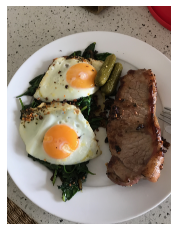

In [65]:
# Viewing our image 
plt.imshow(steak)
plt.axis(False)

In [66]:
# Check the shape of our image 
steak.shape

(4032, 3024, 3)

In [67]:
# Predicting our image with the model 
# model_6.predict(steak) -----> Throws out an error

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-67-01688053ad4c> in <module>()
      1 # Predicting our image with the model
----> 2 model_6.predict(steak)

9 frames
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/func_graph.py in wrapper(*args, **kwargs)
    975           except Exception as e:  # pylint:disable=broad-except
    976             if hasattr(e, "ag_error_metadata"):
--> 977               raise e.ag_error_metadata.to_exception(e)
    978             else:
    979               raise

ValueError: in user code:

    /usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.7/dist-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.7/dist-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.7/dist-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_6 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (32, 3024, 3)

In [68]:
tf.expand_dims(steak , axis = 0).shape

TensorShape([1, 4032, 3024, 3])

In [69]:
# Let's store the above in a variable and predict it 
expanded_steak = tf.expand_dims(steak , axis = 0)
# model_6.predict(expanded_steak) --> We gotta reshape the image back into (224 , 224)

> 🔑 **Note:** When you train a neural network and you want to make a prediction with it on your own custom data, it is important that your custom data or new data is pre-processed into the same format as the data your model was trained on. 

In [70]:
# Create a function to import an image and resize it to be able to be used with our model 
def load_and_prep_image(filename , img_shape = 224):
  '''
  Reads an image from filename an turn it into a tensor, and reshapes it to (img_shape , img_shape , color_channels)
  '''

  # Read in the image 
  img = tf.io.read_file(filename) # input / ouput --> reads and outputs the entire contents of the input filename
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image 
  img = tf.image.resize(img, size = [img_shape , img_shape]) # pass the image and the size we wanted to reshape 
  # Rescale the image and get all values between 0 and 1
  img = img / 255
  return img

`tf.image` --> module contains various functions for image processing and decoding-encoding Ops.

Same is available for other kinds of data like text, audio etc..

[How to load images in tensorflow](https://www.tensorflow.org/tutorials/load_data/images)

In [71]:
# Load in and preprocess our custom image using our function 
steak = load_and_prep_image(filename = '03-steak.jpeg' , img_shape=224)
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [72]:
steak.shape # Alright, we still have batch size missing

TensorShape([224, 224, 3])

In [73]:
# Converting to 4dim so it can be considered as a batch size 
steak = tf.expand_dims(steak , axis = 0)
steak.shape

TensorShape([1, 224, 224, 3])

In [74]:
# Predicting our model with our custom data 
pred = model_6.predict(steak) # output will be a prediction probability 
pred

array([[0.8957249]], dtype=float32)

Looks like our custom image is being put through our model, however, it currently outputs a prediction probability, wouldn't it be nice if we could visualize the image as well as the model's predictions

In [75]:
# Remind ourselves of the class names 
class_names

array(['pizza', 'steak'], dtype='<U9')

In [76]:
# We can index the predicted class by rounding the prediction probabilties and indexing it into the class names
pred_class = class_names[int(tf.round(pred))]
pred_class

'steak'

In [77]:
int(tf.round(pred))

1

In [78]:
piz_img = load_and_prep_image(filename='/content/pizza_steak/test/pizza/420409.jpg' , img_shape=224)
piz_img = tf.expand_dims(piz_img , axis = 0)
piz_img.shape

TensorShape([1, 224, 224, 3])

In [79]:
# Predicting on pizzaa and see what's the result 
class_names[int(tf.round(model_6.predict(piz_img)))]

'pizza'

In [80]:
int(tf.round(model_6.predict(piz_img))) , tf.round(model_6.predict(piz_img))

(0,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>)

In [81]:
def pred_and_plot(model , filename , class_names = class_names):
  '''
  Imports an image located with a filename, makes a prediction with model and 
  plots the image with predicted class as the title
  '''
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction 
  pred = model.predict(tf.expand_dims(img , axis=0))

  # Get the predicted class 
  pred_class = class_names[int(tf.round(pred))]

  # Plot the image and predicted class 
  plt.imshow(img)
  plt.title(f'Prediction: {pred_class}')
  plt.axis(False)

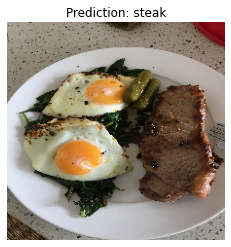

In [82]:
# Test our model on the custom image using our function 
pred_and_plot(model_6 , filename='03-steak.jpeg' , class_names=class_names)

Our model works let's try it on another image. This time pizza 🥳

--2021-03-19 02:21:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.04s   

2021-03-19 02:21:43 (64.5 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



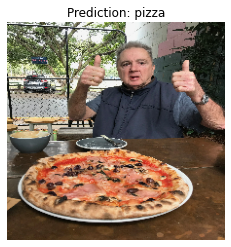

In [83]:
# Download another test custom data and make predictions on it 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
pred_and_plot(model_6 , filename='03-pizza-dad.jpeg')

# Multi-Class Image Classification
We've just been through a bunch of the following steps with a binary classification problem (pizza or steak), now we're going to step things up a notch with **10 classes of food** (multi-class classification).

1. Become one with the data 
2. Pre-process the data get it ready for the model. 
3. Create a model (start with a baseline). 
4. Fit the model (overfit it to make sure it works).
5. Evaluate the model. 
6. Adjust different hyperparameters and improve the model (try to beat baseline/ reduce overfitting).
7. Repeat until satisfied

## 1.Import and become one with the data 

In [84]:
import zipfile 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip our data
zip_ref = zipfile.ZipFile('10_food_classes_all_data.zip' , 'r')
zip_ref.extractall()
zip_ref.close()

--2021-03-19 02:21:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.253.115.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   163MB/s    in 3.0s    

2021-03-19 02:21:46 (163 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [85]:
# Check our data 
import os 

# Walkthrough 10 classes of food image data 
for dirpath , dirnames , filenames in os.walk('10_food_classes_all_data'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

There are 2 directories and 0 images in '10_food_classes_all_data'. 
There are 10 directories and 0 images in '10_food_classes_all_data/test'. 
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'. 
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'. 
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'. 
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'. 
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'. 
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'. 
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'. 
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'. 
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'. 
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.

In [86]:
# Setup train and test directories 
train_dir = '10_food_classes_all_data/train/'
test_dir = '10_food_classes_all_data/test/'

In [87]:
# Let's get the subdirectories (these are just class names)
import pathlib 
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted(item.name for item in data_dir.glob('*')))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [88]:
random.choice(class_names)

'ramen'

The random_image variable returns: ['2495903.jpg']
Image shape: (384, 512, 3)


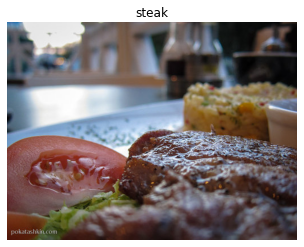

In [89]:
# Visualize , visualize and Visualize 
import random 
img = view_random_image(target_dir=train_dir , 
                        target_class = random.choice(class_names))


## 2. Pre-process the data (prepare it for the model)

In [90]:
# Create train and test data generator and rescale the data (load the data)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale= 1/255.) # It's a class
test_datagen = ImageDataGenerator(rescale= 1/255.) # divide all images by 255 


# Load in our image data from directories and turn them into batches 
train_data = train_datagen.flow_from_directory(directory= train_dir , # target directory of images
                                               target_size = (224 , 224) , # target size of images (height , width)
                                               class_mode = 'categorical' ,  # type of data you're working wiht
                                               batch_size = 32) # size of mini-batches to load data into 

test_data = test_datagen.flow_from_directory(directory= test_dir , 
                                             target_size = (224 , 224) , 
                                             class_mode = 'categorical' , 
                                             batch_size = 32)




Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## 3.Create a model (start with a baseline)

We've been talking alot about the CNN explainer website... How about just take their model and use it for our problem. Replicate the model in CNN explainer website.

In [91]:
# Building a baseline model from the cnn explainer website 
from tensorflow.keras.layers import Dense , Conv2D , MaxPool2D , Flatten
from tensorflow.keras import Sequential 

# Creating the model
base_model = Sequential([
  Conv2D(10 , 3, activation='relu' , input_shape = (224 , 224 , 3)), 
  Conv2D(10 , 3 , activation = 'relu') , 
  MaxPool2D(2 , padding = 'valid'), 
  Conv2D(10 , 3 , activation='relu'), 
  Conv2D(10 , 3, activation='relu'),
  MaxPool2D(2), 
  Flatten(),
  Dense(10 , activation='softmax')
])

# Getting the summary of the model 
base_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 28090)            

In [92]:
# Compile the baseline model 
base_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                   optimizer = tf.keras.optimizers.Adam(), 
                   metrics = ['accuracy'])

# Fit the model 
history = base_model.fit(train_data , 
               epochs = 5,
               steps_per_epoch = len(train_data) , 
               validation_data = test_data , 
               validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 45s 191ms/step - loss: 2.2409 - accuracy: 0.1463 - val_loss: 1.9656 - val_accuracy: 0.2980
Epoch 2/5
235/235 [==============================] - 45s 191ms/step - loss: 1.9059 - accuracy: 0.3438 - val_loss: 1.9271 - val_accuracy: 0.3228
Epoch 3/5
235/235 [==============================] - 45s 191ms/step - loss: 1.5237 - accuracy: 0.4932 - val_loss: 1.9533 - val_accuracy: 0.3316
Epoch 4/5
235/235 [==============================] - 44s 187ms/step - loss: 0.9451 - accuracy: 0.6969 - val_loss: 2.3612 - val_accuracy: 0.2916
Epoch 5/5
235/235 [==============================] - 44s 187ms/step - loss: 0.3943 - accuracy: 0.8851 - val_loss: 3.5912 - val_accuracy: 0.2720


## 5. Evaluate the model 

In [93]:
# Evaluate our model on the test data 
base_model.evaluate(test_data)

79/79 [==============================] - 10s 131ms/step - loss: 3.5912 - accuracy: 0.2720


[3.5912046432495117, 0.2720000147819519]

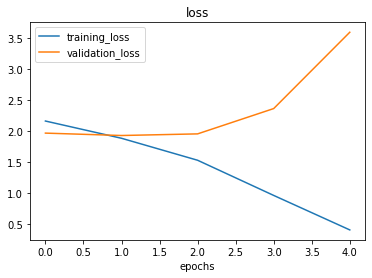

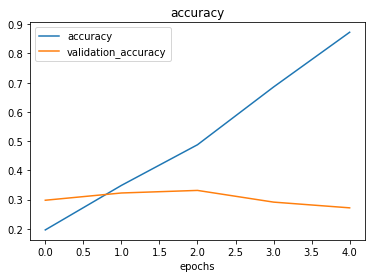

In [94]:
# Check out the models loss curves 
plot_loss_curves(history)

What do these loss curves tell us? 
Our `base_model` is learning the training data too well and failing to generalize on the unseen data. **Overfitting**

## 6. Adjust the model hyperparameters to beat the baseline and reduce overfitting! 

Due to it's performance on the training data it's clear that our model is learning something. However, it's not generalizing well to the unseen data.

So let's try and fix overfitting by....
- **Get more data** - having more data gives a model more opportunity to learn diverse patterns.
- **Simplify the model** - if our current model is overfitting the data, it may be too complicated of a model. One way to simplify the model is to **reduce the number of layers and reduce the number of hidden units in a layer**. 
- **Use data augmentation** - Data Augmentation manipulates the training data in such a way to add more diversity to it (without altering the original data). 
- **Use transfer learning** - transfer learning leverages the patterns other model has learned on similar data to your own and allows 

In [95]:
# How about we try and simplify our model at first? 
# Lets try to remove 2 convolutional layer

model_7 = Sequential([
  Conv2D(10 , 3 , activation='relu' , input_shape = (224 , 224, 3)), 
  MaxPool2D(2), 
  Conv2D(10 , 3 , activation='relu'), 
  MaxPool2D(2), 
  Flatten(), 
  Dense(10 , activation='sigmoid')
])

# Compile the baseline model 
model_7.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                   optimizer = tf.keras.optimizers.Adam(), 
                   metrics = ['accuracy'])

# Fit the model 
simple_history = model_7.fit(train_data , 
               epochs = 5,
               steps_per_epoch = len(train_data) , 
               validation_data = test_data , 
               validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 42s 179ms/step - loss: 2.8262 - accuracy: 0.1716 - val_loss: 1.9727 - val_accuracy: 0.3116
Epoch 2/5
235/235 [==============================] - 42s 177ms/step - loss: 1.8243 - accuracy: 0.3799 - val_loss: 1.9648 - val_accuracy: 0.3064
Epoch 3/5
235/235 [==============================] - 42s 177ms/step - loss: 1.4708 - accuracy: 0.5289 - val_loss: 1.9118 - val_accuracy: 0.3372
Epoch 4/5
235/235 [==============================] - 42s 179ms/step - loss: 1.0032 - accuracy: 0.6967 - val_loss: 2.2471 - val_accuracy: 0.3052
Epoch 5/5
235/235 [==============================] - 42s 179ms/step - loss: 0.6128 - accuracy: 0.8313 - val_loss: 2.6593 - val_accuracy: 0.2980


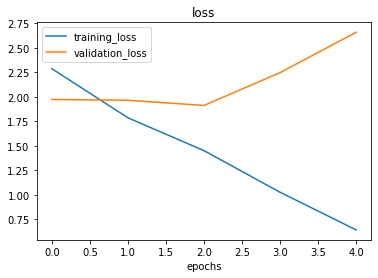

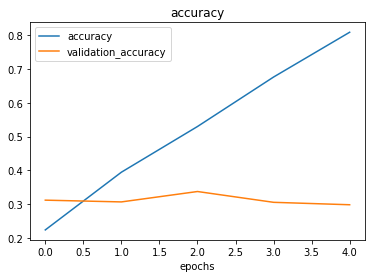

In [96]:
# Let's check the loss curves 
plot_loss_curves(simple_history)

In [97]:
base_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 53, 53, 10)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 28090)            

In [98]:
model_7.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 54, 54, 10)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 29160)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                291610    
Total params: 292,800
Trainable params: 292,800
Non-trainable params: 0
________________________________________________

Looks like our " simplifying our model" experiment didn't work, the accuracy went down and overfitting continued

How about we try data augmentation??

### Try to reduce overfitting with data augmentation

In [118]:
# Creating an instance of the ImageDataGenerator with augmentation 
augmented_datagen = ImageDataGenerator(rescale=1 / 255. , 
                                       horizontal_flip = True, 
                                       shear_range = 0.2 , 
                                       zoom_range = 0.2 
                                       )

# Importing the transforms in our data 
train_data_augmented = augmented_datagen.flow_from_directory(train_dir , 
                                                             target_size = (224 , 224) , 
                                                             batch_size = 32 , 
                                                             shuffle = True , 
                                                             seed = 42 , 
                                                             class_mode = 'categorical')

Found 7500 images belonging to 10 classes.


In [119]:
len(train_data_augmented)

235

In [120]:
# Fitting our data into the tiny_vgg model (base_model)

history_aug_1 = base_model.fit(train_data_augmented , 
                               epochs = 5, 
                               steps_per_epoch = len(train_data_augmented) , 
                               validation_data = test_data , 
                               validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 105s 448ms/step - loss: 1.4926 - accuracy: 0.5060 - val_loss: 1.5387 - val_accuracy: 0.4972
Epoch 2/5
235/235 [==============================] - 105s 447ms/step - loss: 1.4777 - accuracy: 0.5135 - val_loss: 1.5744 - val_accuracy: 0.4900
Epoch 3/5
235/235 [==============================] - 105s 447ms/step - loss: 1.4318 - accuracy: 0.5289 - val_loss: 1.4645 - val_accuracy: 0.5252
Epoch 4/5
235/235 [==============================] - 105s 446ms/step - loss: 1.3937 - accuracy: 0.5383 - val_loss: 1.3947 - val_accuracy: 0.5392
Epoch 5/5
235/235 [==============================] - 105s 448ms/step - loss: 1.3658 - accuracy: 0.5503 - val_loss: 1.4916 - val_accuracy: 0.5192


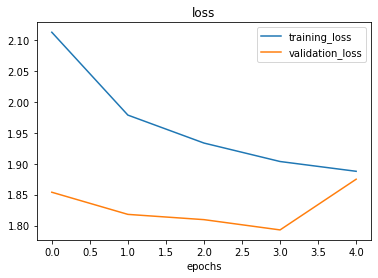

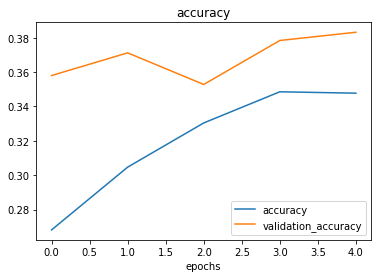

In [101]:
# Plotting the loss curves 
plot_loss_curves(history_aug_1)

In [102]:
# Fitting our simplified model 
history_aug_2 = model_7.fit(train_data_augmented , 
                            epochs = 5 , 
                            steps_per_epoch = len(train_data_augmented),
                            validation_data = test_data , 
                            validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 104s 443ms/step - loss: 2.1602 - accuracy: 0.2495 - val_loss: 1.9403 - val_accuracy: 0.3352
Epoch 2/5
235/235 [==============================] - 104s 443ms/step - loss: 1.9936 - accuracy: 0.3091 - val_loss: 1.8444 - val_accuracy: 0.3688
Epoch 3/5
235/235 [==============================] - 104s 442ms/step - loss: 1.9600 - accuracy: 0.3223 - val_loss: 1.7678 - val_accuracy: 0.3880
Epoch 4/5
235/235 [==============================] - 104s 442ms/step - loss: 1.9090 - accuracy: 0.3411 - val_loss: 1.7552 - val_accuracy: 0.3980
Epoch 5/5
235/235 [==============================] - 104s 442ms/step - loss: 1.8992 - accuracy: 0.3480 - val_loss: 1.7150 - val_accuracy: 0.4168


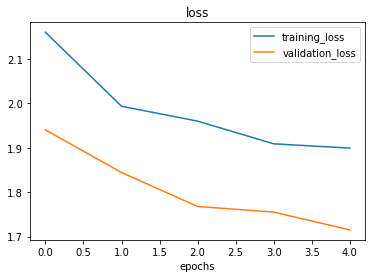

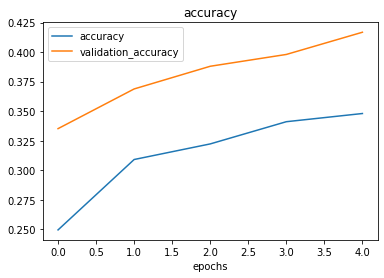

In [103]:
# Plotting the loss curves 
plot_loss_curves(history_aug_2)

That looks much better, the loss curves are much closer to eachother than the baseline model and they look like heading in the right direction (certainly not the wrong direction), so if we train for longer we might see further improvements.

### 7. Repeat until satisfied

In [106]:
# Let's train for more epochs (augmented data on baseline)
# Fitting our data into the tiny_vgg model (base_model)

history_aug_1 = base_model.fit(train_data_augmented , 
                               epochs = 10, 
                               steps_per_epoch = len(train_data_augmented) , 
                               validation_data = test_data , 
                               validation_steps = int(0.15* (len(test_data))))

Epoch 1/10
235/235 [==============================] - 99s 420ms/step - loss: 1.6956 - accuracy: 0.4205 - val_loss: 1.7112 - val_accuracy: 0.4403
Epoch 2/10
235/235 [==============================] - 99s 421ms/step - loss: 1.6815 - accuracy: 0.4357 - val_loss: 1.5760 - val_accuracy: 0.4744
Epoch 3/10
235/235 [==============================] - 99s 420ms/step - loss: 1.6924 - accuracy: 0.4263 - val_loss: 1.6480 - val_accuracy: 0.4631
Epoch 4/10
235/235 [==============================] - 99s 420ms/step - loss: 1.6789 - accuracy: 0.4359 - val_loss: 1.5940 - val_accuracy: 0.5142
Epoch 5/10
235/235 [==============================] - 98s 419ms/step - loss: 1.6708 - accuracy: 0.4363 - val_loss: 1.6417 - val_accuracy: 0.4574
Epoch 6/10
235/235 [==============================] - 99s 419ms/step - loss: 1.6694 - accuracy: 0.4317 - val_loss: 1.6045 - val_accuracy: 0.4915
Epoch 7/10
235/235 [==============================] - 99s 420ms/step - loss: 1.6348 - accuracy: 0.4527 - val_loss: 1.4736 - val_ac

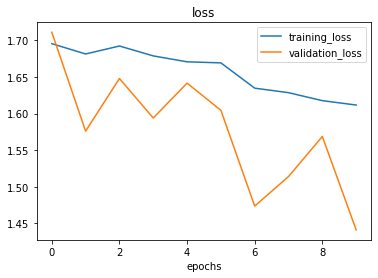

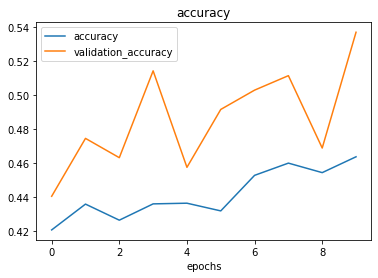

In [107]:
# Plotting the loss curves 
plot_loss_curves(history_aug_1)

We could keep going here...continually trying to bring our loss curves closer together and trying to improve validation/test accuracy. 

How? 

By running alot of experiments, namely:
- Restructuring our model's architecture (increasing layers/hidden units). 
- Adjust the learning rate.
- Try different methods of data augmentation (adjust hyperparameters in our ImageDataGenerator instance). 
- Training for longers (10 epochs or more). 
- Try transfer learning. 


### Making predicitons with our trained model 

Let's use our trained model to make some predictions on our own custom images! 


In [121]:
# Remind ourselves with class names 
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [123]:
# Getting our images 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg



--2021-03-19 04:32:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1725178 (1.6M) [image/jpeg]
Saving to: ‘03-sushi.jpeg.1’

03-sushi.jpeg.1     100%[===================>]   1.64M  --.-KB/s    in 0.02s   

2021-03-19 04:32:28 (79.4 MB/s) - ‘03-sushi.jpeg.1’ saved [1725178/1725178]

--2021-03-19 04:32:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-125-313df157cc05> in <module>()
      2 pred_and_plot(model= base_model , 
      3               filename = '03-pizza-dad.jpeg.2' ,
----> 4               class_names = list(class_names))

1 frames
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py in __int__(self)
    978 
    979   def __int__(self):
--> 980     return int(self._numpy())
    981 
    982   def __long__(self):

TypeError: only size-1 arrays can be converted to Python scalars

In [137]:
def pred_and_plot(model , filename , class_names = class_names):
  '''
  Imports an image located with a filename, makes a prediction with model and 
  plots the image with predicted class as the title
  '''
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction 
  pred = model.predict(tf.expand_dims(img , axis=0))

  # Get the predicted class 
  # Add in logic for multi-class
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]

  # Plot the image and predicted class 
  plt.imshow(img)
  plt.title(f'Prediction: {pred_class}')
  plt.axis(False)

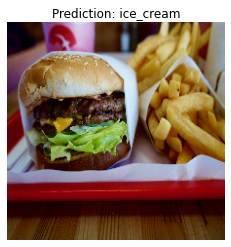

In [146]:
# Make a prediction using base_model 
pred_and_plot(model= base_model , 
             filename = '03-hamburger.jpeg' , 
           class_names = list(class_names))

Looks like our model didn't perform very well on the custom images, this is because our model's accuracy was less than ~45% on the test data. So we expected that our model will do poorly.


### Save and Load the model

In [147]:
# Save a model
base_model.save('saved_poor_model')

INFO:tensorflow:Assets written to: saved_poor_model/assets


In [148]:
# Load in the trained model and evaluate it
loaded_model = tf.keras.models.load_model('saved_poor_model')
loaded_model.evaluate(test_data)

79/79 [==============================] - 10s 130ms/step - loss: 1.4916 - accuracy: 0.5192


[1.491639494895935, 0.5192000269889832]

In [151]:
# Compare our loaded model to existing model 
base_model.evaluate(test_data)

79/79 [==============================] - 10s 130ms/step - loss: 1.4916 - accuracy: 0.5192


[1.4916399717330933, 0.5192000269889832]